In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load data
data = pd.read_csv('/content/drive/MyDrive/Yamaha_cleaned.csv')

In [4]:
print(data)
data.describe()

            Date   Price    Open    High     Low    Volume  Change
0     04/01/2018  432000  421000  432000  420500  11600000    3850
1     05/01/2018  438000  434000  438500  431500   9426000    1390
2     09/01/2018  446500  441500  447000  437500   9687000    1940
3     10/01/2018  452000  447000  453000  446500   7640000    1230
4     11/01/2018  454000  452500  454500  451500   7968000     440
...          ...     ...     ...     ...     ...       ...     ...
1447  08/12/2023  321600  327100  327100  319900  14400000   -1680
1448  11/12/2023  321600  325900  326900  321300   9444000       0
1449  12/12/2023  317600  326900  327100  317400   9914000   -1240
1450  13/12/2023  321800  319000  323000  319000  10400000    1320
1451  14/12/2023  314200  320500  320500  313300  11100000   -2360

[1452 rows x 7 columns]


,Price,Open,High,Low,Volume,Change
count,1452.000000,1452.000000,1452.000000,1452.00000,1.452000e+03,1452.000000
mean,534245.110193,534465.840220,540058.057851,528327.61708,6.088632e+06,1.225895
std,69572.114292,69404.166264,69887.756992,68896.27649,3.185040e+06,2029.921662
min,314200.000000,319000.000000,320500.000000,313300.00000,1.144000e+06,-14570.000000
25%,493875.000000,494000.000000,499000.000000,489000.00000,4.071750e+06,-1132.500000
50%,531500.000000,532000.000000,537000.000000,526000.00000,5.324000e+06,0.000000
75%,577000.000000,579000.000000,584000.000000,572000.00000,7.116750e+06,1070.000000
max,744000.000000,745000.000000,749000.000000,736000.00000,3.140000e+07,12670.000000


In [5]:
# Normalize the 'Price' data
scaler = MinMaxScaler(feature_range=(0, 1))
price_data = data['Price'].values.reshape(-1, 1)
scaled_price = scaler.fit_transform(price_data)

In [6]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(scaled_price, seq_length)

In [7]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [8]:
# Convert the data to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [9]:
# Create TensorDatasets and DataLoaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [10]:
# Set the model parameters
d_model = 64

In [11]:
# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.fc_in = nn.Linear(1, d_model)  # New layer to adjust input feature size
        self.transformer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=128, dropout=0.1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(d_model * seq_length, 64)  # Adjust based on sequence length
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc_in(x)  # Adjust input feature size
        x = self.transformer(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [12]:
# Instantiate the model
model = TransformerModel().to(device)

In [13]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Define the train function
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

In [15]:
# Train the model
train(model, train_loader, criterion, optimizer, epochs=100)

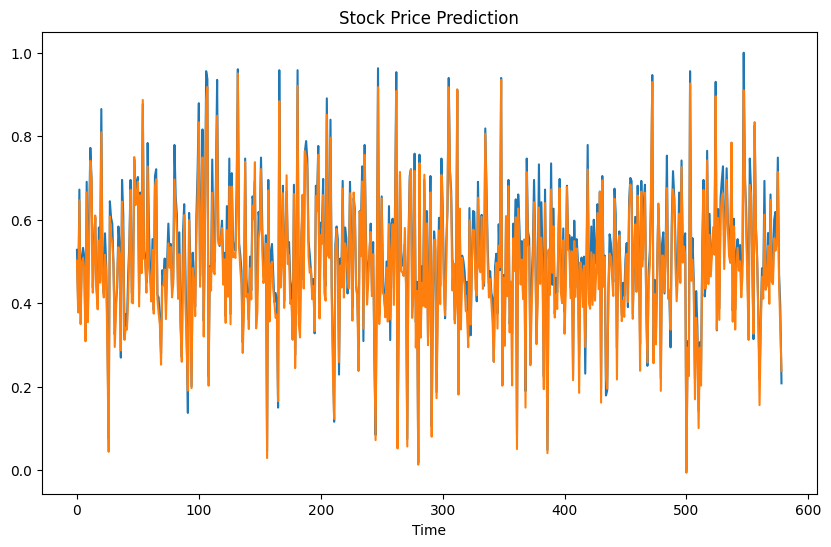

In [16]:
# Visualize the results
def plot_results(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    plt.figure(figsize=(10,6))
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.show()

# Use the plot_results function
plot_results(model, test_loader)

In [17]:
# Function to generate predictions
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.append(y_pred.cpu().detach().numpy())
    return np.vstack(predictions)

In [19]:
# Generate predictions on the test set
test_predictions = predict(model, test_loader)

In [20]:
# Inverse transform to get back to the original scale of prices
test_predictions_original = scaler.inverse_transform(test_predictions).flatten()

In [21]:
# Prepare the date index for plotting
dates = data['Date'].reset_index(drop=True)

In [22]:
# Generate predictions
train_pred = predict(model, train_loader)
test_pred = predict(model, test_loader)

In [23]:
# Inverse transform to get back to the original scale of prices
train_pred_original = scaler.inverse_transform(train_pred).flatten()
test_pred_original = scaler.inverse_transform(test_pred).flatten()

In [24]:
# Create separate dataframes for training and testing predictions
train_dates = dates[:len(train_pred_original)]
test_dates = dates[len(train_pred_original):len(train_pred_original) + len(test_pred_original)]

train_df = pd.DataFrame({'Date': train_dates, 'Price': train_pred_original})
test_df = pd.DataFrame({'Date': test_dates, 'Price': test_pred_original})

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch.nn.functional as F

# Function to calculate Mean Absolute Error (MAE)
def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate Root Mean Squared Error (RMSE)
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate Huber Loss
def calculate_huber_loss(y_true, y_pred, delta=1.0):
    loss = F.smooth_l1_loss(y_pred, y_true, reduction='none')
    loss = torch.where(loss < delta, 0.5 * loss ** 2, delta * (loss - 0.5 * delta))
    return loss.mean().item()

# Assuming you have the actual test prices (y_test) and predictions (test_predictions_original)
mae_value = calculate_mae(y_test, test_predictions_original)
mape_value = calculate_mape(y_test, test_predictions_original)
rmse_value = calculate_rmse(y_test, test_predictions_original)
# Assuming you have the actual test prices (y_test) and predictions (test_predictions_original)
huber_loss_value = calculate_huber_loss(torch.tensor(y_test), torch.tensor(test_predictions_original), delta=1.0)

print(f'MAE: {mae_value}')
print(f'MAPE: {mape_value}')
print(f'RMSE: {rmse_value}')
print(f'Huber Loss: {huber_loss_value}')

MAE: 524507.0414956077
MAPE: inf
RMSE: 529087.043603312
Huber Loss: 524506.0414956077


<ipython-input-25-65979ea7bfe3>:10: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-25-65979ea7bfe3>:18: UserWarning: Using a target size (torch.Size([579, 1])) that is different to the input size (torch.Size([579])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(y_pred, y_true, reduction='none')


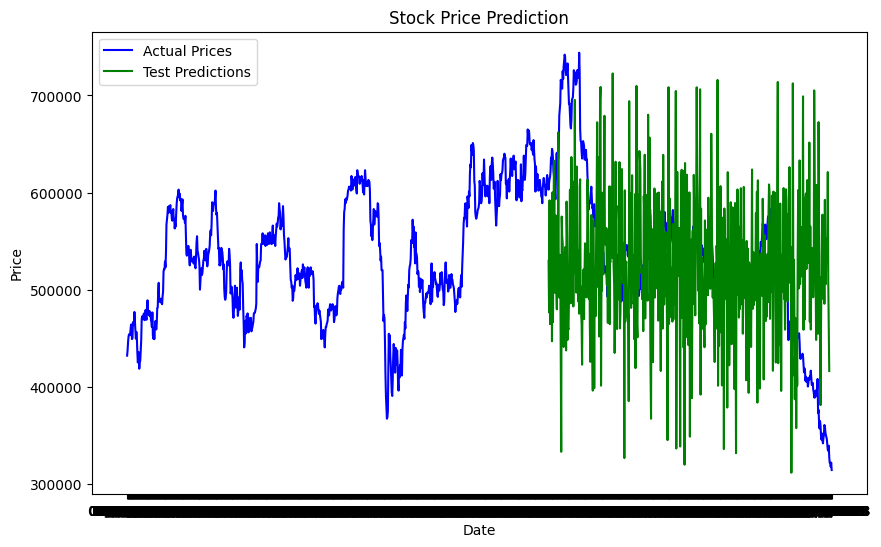

In [26]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Price'], label='Actual Prices', color='blue')
plt.plot(test_df['Date'], test_df['Price'], label='Test Predictions', color='green')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()